[Back to main](analyze.ipynb)

# AlphaGo Zero Inspired Tic-Tac-Toe AI

## Overview

This project demonstrates the capabilities of the AlphaGo Zero algorithm by implementing a simplified version for the game of Tic-Tac-Toe. Our aim is to exhibit how a neural network can autonomously learn and master a game through self-play, without relying on human-generated data or predefined strategies.

## Process Summary

### Step 1: Game Environment Setup
- **Tic-Tac-Toe Implementation**: We start by creating a basic game of Tic-Tac-Toe, defining the rules, moves, and conditions for winning or drawing.
- **Game State Representation**: The board is represented in a way that's easily interpretable by the neural network, with states indicating the presence of 'X', 'O', or a blank space.

### Step 2: Neural Network Creation
- **Dual-Headed Network**: A neural network with two outputs is constructed; one head predicts the probability of winning from a given board state (policy head), while the other estimates the value or quality of that state (value head).
- **Training Infrastructure**: We establish the training infrastructure necessary to optimize the network's parameters using backpropagation and gradient descent techniques.

### Step 3: Monte Carlo Tree Search (MCTS) Integration
- **Search Algorithm**: MCTS is integrated to enable the AI to consider future possibilities in a tree-like structure, allowing it to choose moves that lead to the most favorable outcomes.
- **Neural Network Guidance**: The neural network informs the MCTS by evaluating the quality of board states and guiding the selection of moves during the search process.

### Step 4: Self-Play Loop
- **Data Generation**: Through self-play, the AI plays games against itself, generating data that captures a wide variety of game scenarios and outcomes.
- **Continuous Learning**: After each game, the network is trained on the new data, incrementally improving its ability to predict and evaluate board states.

### Step 5: Human Interaction Mode
- **Difficulty Levels**: The AI can be challenged at different difficulty settings, allowing users to play against a more or less sophisticated opponent based on the depth of MCTS simulations.
- **Human vs. AI**: A mode is provided where users can input their moves and observe how the AI responds, offering an interactive experience with the system.

## Purpose and Usage

The primary objective of this project is to showcase an AI that can reach high levels of play in Tic-Tac-Toe through the mechanisms of the AlphaGo Zero algorithm. Users can interact with the AI, observe its learning process, and understand the underlying techniques that allow it to improve autonomously.

### Exploring the Code
- **Model Loading**: Models can be loaded from the `Models` directory to compare different training stages or to continue training.
- **Game Visualization**: The game's state can be visualized at each step, providing insight into the AI's decision-making process.
- **Self-Play and Training**: Users can initiate self-play sessions to generate new training data and refine the AI's strategies further.

## Importing libraries

In [1]:
from IPython.display import Image
import tensorflow as tf
import numpy as np
import random
import torch
from torch import nn, optim
# import torch.nn as nn
# import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
# If you have a GPU, the following lines will configure TensorFlow to use the GPU for training.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Implementing Tic-Tac-Toe

To understand the AlphaGo Zero algorithm's self-play mechanism, we'll first need a game environment. Here, we are using the classic game of Tic-Tac-Toe as a simplified example. The rules are simple:

- The game is played on a 3x3 grid.
- There are two players: X and O.
- Players take turns, marking the spaces with X or O.
- The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row wins the game.
- If all the spaces are filled but neither player has won, the game is a draw.
- The game can also end in a draw if both players are playing optimally.
- Here's an example game played on a 3x3 grid:

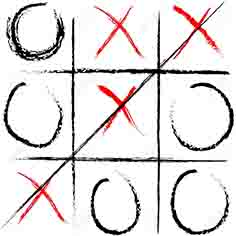

In [3]:
# Show the image with a given size
Image(filename='./Images/tic-tac-toe-clipart-13.jpg', width=150, height=150)

In [4]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1  # 1 for 'X' and -1 for 'O'
    
    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
    
    def available_moves(self):
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]
    
    def available_moves_numbers(self):
        return [i * 3 + j for i in range(3) for j in range(3) if self.board[i, j] == 0]
    
    def make_move(self, move):
        if move in self.available_moves():
            self.board[move] = self.current_player
            self.current_player *= -1
            return True
        return False
    
    def check_win(self):
        # Check rows, columns, diagonals for a win
        for i in range(3):
             if np.all(self.board[i, :] == 1) or np.all(self.board[:, i] == 1):
                 return 1
             elif np.all(self.board[i, :] == -1) or np.all(self.board[:, i] == -1):
                 return -1
        if (self.board[0, 0] == self.board[1, 1] == self.board[2, 2] == 1) or \
           (self.board[0, 2] == self.board[1, 1] == self.board[2, 0] == 1):
            return 1
        elif (self.board[0, 0] == self.board[1, 1] == self.board[2, 2] == -1) or \
             (self.board[0, 2] == self.board[1, 1] == self.board[2, 0] == -1):
            return -1
        return 0  # No winner
    
    def check_draw(self):
        return len(self.available_moves()) == 0
    
    def play_random_game(self):
      self.reset()
      while True:
          if self.check_win():
              return self.current_player
          elif self.check_draw():
              return 0
          move = random.choice(self.available_moves())
          self.make_move(move)
          
    def display(self):
        for row in self.board:
            print('|'.join(['X' if cell == 1 else 'O' if cell == -1 else ' ' for cell in row]))
            print('-' * 5)      
    
# Let's test the game by playing a random game
game = TicTacToe()
winner = game.play_random_game()
if(winner == 0):
    print("Draw")
elif(winner == 1):
    print("Player", winner, "wins")
else:
    print("Player", winner, "wins")

Player 1 wins


### The `TicTacToe` Class

This class encapsulates the entire game logic, providing methods to manage the game board, make moves, and determine the game outcome.

#### 1. `__init__(self)`:

- Initializes the game board as a 3x3 matrix filled with zeros. Zero indicates an empty spot.
- Sets the `current_player` to `1`. In this game, `1` represents player 'X' and `-1` represents player 'O'.

#### 2. `reset(self)`:

- Resets the game board to its initial state.
- Resets the current player to 'X'.

#### 3. `available_moves(self)`:

- Returns a list of tuples, where each tuple represents a free spot `(i, j)` on the board.

#### 4. `make_move(self, move)`:

- Allows the `current_player` to make a move on the board.
- If the move is valid (i.e., the spot is free), the method updates the board and switches the `current_player`.
- Returns `True` if the move was successful, otherwise `False`.

#### 5. `check_win(self)`:

- Checks if the current player has won the game.
- This is done by checking for a full row, column, or diagonal that is occupied solely by the `current_player`'s marker.
- Returns `True` if the current player has won, otherwise `False`.

#### 6. `check_draw(self)`:

- Determines if the game has ended in a draw.
- A draw occurs when all spots on the board are filled, and neither player has won.
- Returns `True` if the game is a draw, otherwise `False`.

#### 7. `play_random_game(self)`:

- Simulates a full game where both players make random moves until the game concludes.
- At the end of the game, returns the winner (`1` for 'X', `-1` for 'O') or `0` if the game was a draw.

### Testing the Game

The code concludes with a test to simulate a game of Tic-Tac-Toe where both players make random moves. The outcome (`winner`) indicates the winning player or a draw.

### Neural Network

Our neural network model consists of convolutional layers followed by fully connected layers. The dual-head architecture outputs both the policy and value.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.5)  # 50% dropout after convolutional layer
        self.fc1 = nn.Linear(16 * 3 * 3, 32)
        self.dropout2 = nn.Dropout(0.5)  # 50% dropout after first fully connected layer
        self.fc2 = nn.Linear(32, 3 * 3)  # output size: number of possible moves (3x3 board)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Test the neural network with a random board state
nn_model = NeuralNetwork()
sample_board = torch.tensor(game.board, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 3, 3]
nn_output = nn_model(sample_board)
nn_output

tensor([[-0.1352, -0.0126,  0.1776, -0.0498,  0.1983,  0.0304, -0.2198,  0.0795,
          0.1156]], grad_fn=<AddmmBackward0>)

1. **NeuralNetwork**:
Това е основният клас, който представя вашата невронна мрежа. Той наследява `nn.Module`, което е базовият клас за всички невронни мрежи в PyTorch.

1. **self.conv**:
Това е свъртъчен слой (Convolutional Layer). Свъртъчните слоеве са много популярни в областта на обработката на изображения и използват малък "филтър" или "ядро", което "пълзи" през входните данни (в този случай, дъската за игра) и прилага свъртъчна операция. Този слой може да научи локални шаблони в данните.
   - `in_channels=1`: Игралната дъска има само един канал, тъй като тя е в черно и бяло (или, по-точно, празно, X или O).
   - `out_channels=16`: Това определя колко филтъра да се научат. В случая, мрежата ще научи 16 различни локални шаблони.
   - `kernel_size=3`: Размерът на филтъра е 3x3.
   - `stride=1`: Филтърът се премества с 1 пиксел на стъпка.
   - `padding=1`: Добавя се допълнително падинг от 1 пиксел около дъската, така че изходната големина след свъртането да бъде същата като входната големина.

1. **self.dropout1** и **self.dropout2**:
Това са слоеве за изключване (Dropout Layers). Изключването е техника за регуларизация, която "изключва" случайно избрани неврони по време на обучението. Това помага да се предотврати преобучаването на мрежата. Във вашия модел използвате 50% вероятност за изключване след свъртъчния слой и след първия напълно свързан слой.

1. **self.fc1** и **self.fc2**:
Това са напълно свързани слоеве (Fully Connected Layers) или линейни слоеве. Те комбинират характеристиките, научени от предходните слоеве, и ги преобразуват в окончателния изход на мрежата.
   - `self.fc1` преобразува данните от 16 * 3 * 3 до 32.
   - `self.fc2` преобразува данните от 32 до 9 (броя на възможните ходове в 3x3 дъска).

1. **forward**:
Това е методът, който определя как данните преминават през мрежата. Входните данни (`x`) преминават последователно през всеки слой, като се прилагат активационни функции и други преобразувания.

1. **optimizer**:
Това е оптимизаторът, който ще използвате, за да обучите вашата мрежа. Използвате `Adam` оптимизатор със скорост на обучение 0.001 и L2 регуларизация (чрез `weight_decay=0.01`). Adam е популярен оптимизатор, който комбинира идеите на два други оптимизатора - AdaGrad и RMSProp.

---

### Monte Carlo Tree Search (MCTS)

Using the neural network, we guide our MCTS to efficiently explore the game tree and make decisions.

## Enhanced Dual-Head Neural Network for AI Learning

We've introduced an improved neural network architecture designed specifically for learning complex strategies in games like Tic-tac-toe. This model is inspired by the AlphaZero algorithm, which combines Monte Carlo tree search (MCTS) with neural networks to make decisions.

### Components Explanation:

1. **Convolutional Layer (self.conv)**:
   - The number of filters has been increased to 32 from the original design. This enhancement allows the network to identify a greater variety of local patterns on the game board, which is critical for understanding the intricacies of game strategy.

2. **Fully Connected Layers (self.fc1, self.fc2, self.fc3)**:
   - A new layer (self.fc2) has been added, scaling the representation from 64 to 128. This additional depth enables the network to learn more complex abstractions of the game state.

3. **Dual Network Heads (self.fc_policy and self.fc_value)**:
   - **self.fc_policy**: This head of the network predicts the policy, i.e., the probabilities of each possible move. The output of this head will be used in the MCTS to determine the most promising move to explore further.
   - **self.fc_value**: This head predicts the value of the current board state. It outputs a scalar value between -1 and 1, where -1 indicates an impending loss, and 1 indicates a likely victory for the current player. This value aids MCTS in appraising whether a board state is favorable or not.

4. **Forward Method**:
   - This method ensures the sequential flow of data through each layer of the network. After processing, the data is bifurcated into two distinct heads for policy and value, guiding both move selection and game state evaluation.

### In the Context of MCTS:

AlphaZero's MCTS leverages the outputs of these two heads during its search for the optimal move. The policy head guides the search direction, suggesting areas for exploration, while the value head evaluates the potential endgame outcomes of moves without the need to simulate the entire game to its conclusion.

### Implementation Details:

In [6]:
class ImprovedDualHeadNeuralNetwork(nn.Module):
    def __init__(self):
        super(ImprovedDualHeadNeuralNetwork, self).__init__()
        
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 3 * 3, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 256)
        self.fc_policy = nn.Linear(256, 3 * 3)  # Change here
        self.fc_value = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc3(x))

        policy = self.fc_policy(x)
        value = torch.tanh(self.fc_value(x))
        return policy, value
    
# Create a dual-head neural network model
dual_nn_model = ImprovedDualHeadNeuralNetwork()
dual_nn_model_old = ImprovedDualHeadNeuralNetwork()

initial_learning_rate = 0.005

optimizer = optim.Adam(dual_nn_model.parameters(), lr=initial_learning_rate)

This powerful combination allows AlphaZero to harness the strengths of Monte Carlo tree search along with the deep learning capabilities of neural networks, leading to a formidable AI capable of strategic gameplay.

---

## Enhanced Neural Network for Strategic Game Evaluation

This code describes an enhanced neural network model tailored for analyzing game states and making predictions in strategic games like Tic-tac-toe. The network utilizes separate pathways for determining the next best move (policy) and the value of the current game state.

### Component Breakdown:

1. **Convolutional Layers (self.conv1, self.conv2, self.conv3)**:
   - A series of convolutional layers with increasing filter sizes (32, 64, and 128) to extract increasingly complex features from the input board state. This hierarchical feature extraction is key for understanding spatial hierarchies in game strategies.

2. **Policy Pathway (self.fc1_policy, self.fc2_policy, self.fc3_policy)**:
   - This pathway consists of fully connected layers that process the features extracted by the convolutional layers to predict the policy, i.e., the likelihood of each possible move being the optimal one. It culminates in an output of 9 units corresponding to the 9 possible moves in Tic-tac-toe.

3. **Value Pathway (self.fc1_value, self.fc2_value, self.fc3_value)**:
   - Parallel to the policy pathway, the value pathway also comprises fully connected layers that conclude in a single output unit. This unit predicts the value of the board state, ranging from -1 (loss) to 1 (win), providing an estimate of the current player's chances.

4. **Activation Functions**:
   - Leaky ReLU is used for non-linear activations throughout the network, allowing for a small gradient when the unit is not active, which can help maintain gradient flow during backpropagation.

5. **Dropout Layers (self.dropout1, self.dropout2_policy, self.dropout3_policy, self.dropout2_value, self.dropout3_value)**:
   - Dropout is incorporated after each layer to prevent overfitting by randomly "dropping out" a subset of activations, forcing the network to learn more robust features.

6. **Forward Method**:
   - Defines the data flow through the network, splitting into the two heads for policy and value. The method ensures that each head receives the appropriate feature representation to make its specific predictions.

### Implementation Example:

In [7]:
class EnhancedNeuralNetwork(nn.Module):
    def __init__(self):
        super(EnhancedNeuralNetwork, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.dropout1 = nn.Dropout(0.4)
        
        # Fully connected layers for policy output
        self.fc1_policy = nn.Linear(128 * 3 * 3, 256)
        self.dropout2_policy = nn.Dropout(0.4)
        self.fc2_policy = nn.Linear(256, 512)
        self.dropout3_policy = nn.Dropout(0.4)
        self.fc3_policy = nn.Linear(512, 9)  # 9 possible moves in TicTacToe
        
        # Fully connected layers for value output
        self.fc1_value = nn.Linear(128 * 3 * 3, 256)
        self.dropout2_value = nn.Dropout(0.4)
        self.fc2_value = nn.Linear(256, 512)
        self.dropout3_value = nn.Dropout(0.4)
        self.fc3_value = nn.Linear(512, 1)  # Scalar value for game state

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        
        # Policy head
        x_policy = F.leaky_relu(self.fc1_policy(x))
        x_policy = self.dropout2_policy(x_policy)
        x_policy = F.leaky_relu(self.fc2_policy(x_policy))
        x_policy = self.dropout3_policy(x_policy)
        x_policy = self.fc3_policy(x_policy)
        
        # Value head
        x_value = F.leaky_relu(self.fc1_value(x))
        x_value = self.dropout2_value(x_value)
        x_value = F.leaky_relu(self.fc2_value(x_value))
        x_value = self.dropout3_value(x_value)
        x_value = torch.tanh(self.fc3_value(x_value))  # Values are between -1 and 1
        
        return x_policy, x_value


# Test the enhanced neural network with a random board state
enhanced_model = EnhancedNeuralNetwork()
sample_board = torch.tensor(game.board, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 3, 3]
enhanced_output = enhanced_model(sample_board)
print(enhanced_output)


(tensor([[ 2.7929e-02,  1.7175e-02,  5.9614e-02,  4.5734e-02, -4.6572e-02,
          5.3506e-05, -8.0439e-02,  8.3668e-03,  2.0342e-02]],
       grad_fn=<AddmmBackward0>), tensor([[-0.0317]], grad_fn=<TanhBackward0>))


This code snippet initializes the enhanced neural network and runs a forward pass with a sample board state. The printed output includes both the policy and value predictions, demonstrating the dual-head architecture's capability to evaluate and suggest moves.

---

## Monte Carlo Tree Search (MCTS) for Strategic Game Play

This description outlines the Monte Carlo Tree Search (MCTS) algorithm, a powerful technique for making decisions in strategic games like Tic-tac-toe, using a combination of tree search and neural network-based evaluation.

### Key Components of MCTS:

1. **MCTSNode Class**:
   - Represents a state in the game as a node in the search tree.
   - Contains information about the game state (`state`), the move that led to this state (`move`), the parent node (`parent`), and the list of child nodes (`children`).
   - Tracks the number of times the node has been visited (`visits`) and the cumulative value of those visits (`value`), which reflects the node's quality.
   - The `is_terminal` method checks if the current state is a winning or drawing state, concluding the game.

2. **MCTS Class**:
   - Holds the neural network model (`model`), the number of simulations to run (`num_simulations`), and the exploration weight (`exploration_weight`), a parameter that balances exploration of less-visited nodes against exploitation of known good nodes.

3. **Search Method**:
   - Manages the overall MCTS process for a given node. It starts by expanding the node if it has no children.
   - Runs several simulations (`num_simulations`) to evaluate potential moves, consisting of traversing the tree to find a leaf node, simulating the outcome from that node, and backpropagating the result.
   - Selects and returns the move leading to the child node with the highest value, indicating the best next move.

4. **Traverse Method**:
   - Guides the path through the search tree to find a leaf node using the `select_best_child` method.
   - Expands the tree if a non-terminal leaf node is found.

5. **Select Best Child Method**:
   - Utilizes the Upper Confidence Bound for Trees (UCT) formula to balance exploration and exploitation. The formula considers both the value per visit (exploitation) and the proportion of overall visits (exploration).

6. **Expand Method**:
   - Adds all possible moves from the current state as new child nodes.
   - Determines the current player based on the game state and generates child nodes for each potential move, updating the tree with new possible game states.

7. **Rollout Method**:
   - Employs the neural network to provide a value estimation for the node, essentially predicting the outcome of the game from the given state.
   - The value is used to simulate the result of playing out the game from that node without conducting a full search.

8. **Backpropagate Method**:
   - Updates the values and visit counts of the nodes from the leaf node up to the root based on the result of the simulation.
   - This method ensures that the tree accumulates knowledge from the simulations over time, leading to better predictions of the value of each move.

In [8]:
class MCTSNode:
    def __init__(self, state, move=None, parent=None):
        self.state = state
        self.move = move  # The move that led to this state
        self.parent = parent
        self.children = []
        self.visits = 0
        self.value = 0

    def is_terminal(self):
        game = TicTacToe()
        game.board = self.state
        return game.check_win() or game.check_draw()

class MCTS:
    def __init__(self, model, num_simulations=200, exploration_weight=1.0):
        self.model = model
        self.num_simulations = num_simulations
        self.exploration_weight = exploration_weight

    def search(self, node):
         if not node.children:  # Ако възелът няма деца, първо го разширяваме
             self.expand(node)
                 
         for _ in range(self.num_simulations):
             leaf_node = self.traverse(node)
             simulation_result = self.rollout(leaf_node)
             self.backpropagate(leaf_node, simulation_result)
        
         # Тук добавяме проверката:
         if node.children:
             best_child = max(node.children, key=lambda child: child.value)
             return best_child.move
         else:
             # Handle the case when there are no children, e.g., return a default move or raise an exception.
             raise ValueError("No available moves for the current node.")


    def traverse(self, node):
        """
        Traverse the tree until we reach a leaf node.
        """
        while node.children:
            node = self.select_best_child(node)
        # If the node is a leaf and not a terminal state, expand it.
        if not node.is_terminal():
            self.expand(node)
        return node
    
    def select_best_child(self, node):
         """
         Select the best child node based on the UCT formula.
         """
         # Calculate total visits of all children of the node
         total_visits = sum(child.visits for child in node.children)

         # Check if the opponent is about to win
         for child in node.children:
             game = TicTacToe()
             game.board = child.state
             if game.check_win():
                 return child

         def uct(child):
             """
             Upper Confidence Bound for Trees (UCT) formula.
             """
             if child.visits == 0:
                 return float('inf')  # prioritize unvisited child
             exploitation_value = child.value / child.visits  # Expected value
             exploration_value = self.exploration_weight * np.sqrt(np.log(total_visits) / child.visits)
             return exploitation_value + exploration_value

         return max(node.children, key=uct)

    
    def expand(self, node):
        """
        Expand the current node by adding all possible moves from its state as children.
        """
        
        # Determine the current player. This assumes players are represented as 1 and -1.
        current_player = 1 if np.sum(node.state) == 0 else -1 
    
        # Create a temporary game instance to check available moves.
        game = TicTacToe()
        game.board = np.copy(node.state)
    
        # Loop through available moves and expand the node.
        for move in game.available_moves():
            child_state = np.copy(node.state)
            child_state[move] = current_player
            child_node = MCTSNode(child_state, move=move, parent=node)
            node.children.append(child_node)

    def rollout(self, node):
        """
        Use the neural network to get the value estimate for the node.
        """
        current_player = 1 if np.sum(node.state) == 0 else -1
        with torch.no_grad():
            board_tensor = torch.tensor(node.state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            _, value = self.model(board_tensor)
        return current_player * value.item()


    def backpropagate(self, node, result):
        """
        Update the node values based on the simulation result.
        """
        while node:
            node.visits += 1
            node.value += result
            node = node.parent

# Test the MCTS search method
mcts = MCTS(dual_nn_model, num_simulations=100)
game = TicTacToe()
root_node = MCTSNode(game.board)
best_move = mcts.search(root_node)
best_move

(0, 1)

## Enhancing MCTS with Neural Networks for Advanced Strategy Games

The advanced Monte Carlo Tree Search (MCTS) algorithm integrates with a neural network to form a robust decision-making tool for complex strategy games. This integration not only enables the MCTS to make more informed choices but also allows the collection of valuable training data for improving the neural network model. Here's an overview of the advanced MCTS class and its functions:

### MCTSWithNN Class:

This subclass of `MCTS` extends its functionality to interact with a neural network and collect training data.

### Training Data Collection:

During the MCTS simulations, the `collect_training_data` method accumulates data for training the neural network. The data includes tuples of (board state, policy, value):

- **Board States**: The different game states encountered during simulations.
- **Policies**: The move probabilities as determined by the normalized visit counts from each state.
- **Values**: The outcomes of the simulations, representing whether the current player is likely to win (+1), lose (-1), or draw (0).

### Normalizing Visit Counts:

The `get_policy` method converts the visit counts of a node's children into a probability distribution (policy). This policy reflects the relative frequencies of each move being chosen during the simulations, providing insight into which moves are more promising based on the current state.

### Search Method:

The `search` method orchestrates the MCTS process, similar to the base `MCTS` class. It includes:

- **Expansion**: If the current node has no children, it is expanded to include all possible moves.
- **Simulation**: Multiple simulations are run, where each involves traversing the tree to find a leaf node, simulating the outcome, and then backpropagating the result to update the node's statistics.
- **Best Move Selection**: After simulations, the method selects the move leading to the child with the highest value, suggesting it as the best next move.

### Error Handling:

The search method includes a check for the case where no children are available. If no moves can be made, an exception is raised, indicating an error in the game logic or the end of the game.

### Integration with Neural Networks:

By leveraging the predictive capabilities of neural networks, this advanced MCTS can evaluate game states and potential moves with more depth than traditional heuristics. The neural network provides an estimated value for each game state, which is used to simulate outcomes and refine the search process.

The training data collected during MCTS simulations is used to continually improve the neural network's performance. As the network learns from the accumulated data, it provides more accurate predictions, which in turn leads to more effective MCTS searches. This symbiotic relationship forms the core of learning in advanced AI systems for strategic games.

In [9]:
# First, we need to modify our MCTS class to collect training data
# The training data consists of (board state, policy, value) tuples
# Policy is the normalized visit counts of all actions from a state
# Value is the result of the game from the current player's perspective

class MCTSWithNN(MCTS):
    def __init__(self, model, num_simulations=200, exploration_weight=1.0):
        super().__init__(model, num_simulations, exploration_weight)

    def collect_training_data(self, node):
        """Collect training data during MCTS simulations."""
        board_states, policies, values = [], [], []
        
        for _ in range(self.num_simulations):
            leaf_node = self.traverse(node)
            simulation_result = self.rollout(leaf_node)
            self.backpropagate(leaf_node, simulation_result)
            
            board_states.append(leaf_node.state)
            policy = self.get_policy(leaf_node)
            value = simulation_result
            policies.append(policy)
            values.append(value)
        
        return board_states, policies, values
    
    def get_policy(self, node):
        """Get the normalized visit counts of all actions from the given node."""
        total_visits = sum(child.visits for child in node.children)
        
        # If no child of the node was visited, return a uniform policy
        if total_visits == 0:
            return np.ones(9) / 9
        
        policy = np.zeros(9)  # 9 possible moves in TicTacToe
        for child in node.children:
            policy[child.move[0] * 3 + child.move[1]] = child.visits / total_visits
        return policy
    
    def search(self, node):
      if not node.children:  # If the node has no children, expand it first.
          self.expand(node)
              
      for _ in range(self.num_simulations):
          leaf_node = self.traverse(node)
          simulation_result = self.rollout(leaf_node)
          self.backpropagate(leaf_node, simulation_result)
    
      # Here we add the check:
      if node.children:
          best_child = max(node.children, key=lambda child: child.value)
          return best_child.move
      else:
          # Handle the case when there are no children, e.g., return a default move or raise an exception.
          raise ValueError("No available moves for the current node.")

In [10]:
class MCTSWithNNAndTraining(MCTSWithNN):
    def __init__(self, model, num_simulations=200, exploration_weight=1.0):
        super().__init__(model, num_simulations, exploration_weight)
        self.training_data = []  # Store training data as (board_state, policy, value) tuples

    def search_and_collect_data(self, node):
        """
        Use MCTS to search for the best move and collect training data along the way.
        """
        best_move = self.search(node)
        board_states, policies, values = self.collect_training_data(node)
        self.training_data.extend(zip(board_states, policies, values))
        return best_move

    def get_training_data(self):
        """Retrieve the collected training data."""
        return self.training_data

    def clear_training_data(self):
        """Clear the collected training data."""
        self.training_data = []


# Update the MCTS instance with the new class
mcts_with_training = MCTSWithNNAndTraining(dual_nn_model, num_simulations=1000000)

## Training and Self-Play Loop for Reinforcement Learning

In the quest to refine an AI model for strategic games like TicTacToe, a combination of self-play and training is employed. This methodology is instrumental in enhancing the model's ability to predict and evaluate game states. Below is a detailed breakdown of the self-play and training processes, including the data collection and model optimization phases.

### Self-Play Function:

`self_play(model, mcts_simulations)` orchestrates a complete game of TicTacToe by simulating both players using the Monte Carlo Tree Search (MCTS) informed by a neural network.

- **Game Initialization**: A new game instance is created, and an MCTS object is instantiated with the provided model.
- **Memory Preallocation**: Arrays for storing board states, policies, and values are preallocated, assuming a maximum of 9 moves (the total number of cells in TicTacToe).
- **Game Loop**: The game continues in a loop until a win or draw is detected. During each iteration:
  - A new root node is created from the current game state.
  - The MCTS's policy for the next move is computed.
  - The best move is determined and executed on the game board.
  - The board state and policy are stored for future training.

- **Winner Determination**: Once the game ends, the outcome is backtracked to assign values (-1, 0, +1) to all previous moves depending on the final result.

In [11]:
# from torch.optim.lr_scheduler import StepLR

def self_play(model, mcts_simulations=mcts_with_training):
    game = TicTacToe()
    mcts = MCTSWithNN(model, num_simulations=mcts_simulations)
    
    # Предварително заделяне на паметта
    max_moves = 9  # максимален брой ходове в TicTacToe
    boards = [None] * max_moves
    policies = [None] * max_moves
    values = [None] * max_moves
    current_move = 0
    
    while True:
        root_node = MCTSNode(game.board)
        policy = mcts.get_policy(root_node)
        best_move = mcts.search(root_node)
        
        # Запазете дъската и политиката за обучение
        boards[current_move] = game.board.copy()
        policies[current_move] = policy
        
        game.make_move(best_move)
        current_move += 1
        
        if game.check_win():
            winner = -game.current_player
            break
        elif game.check_draw():
            winner = 0
            break
    
    for i in range(current_move):
        if np.sum(boards[i]) == winner:
            values[i] = -1.0
        elif np.sum(boards[i]) == -winner:
            values[i] = 1.0
        else:
            values[i] = 0.0    
    
    # Отрежете ненужните части от списъците
    boards = boards[:current_move]
    policies = policies[:current_move]
    values = values[:current_move]
    
    return boards, policies, values

### Training Function:

`train_model(model, training_data, num_epochs, learning_rate)` is responsible for optimizing the neural network's weights based on the collected training data.

- **Optimizer Setup**: An Adam optimizer is used for adjusting the weights, with an initial learning rate provided as an argument.
- **Loss Functions**: Separate loss functions for policy (CrossEntropyLoss) and value (MSELoss) predictions are defined.
- **Learning Rate Scheduler**: A `ReduceLROnPlateau` scheduler adjusts the learning rate based on the loss, promoting better convergence.
- **Data Preparation**: Training data (board states, policies, values) is converted into tensors, the format required for processing by the neural network.
- **Training Loop**: For each epoch, the model predicts policy and value from the board states, calculates the loss, and performs backpropagation to update the weights.
- **Early Stopping**: Training stops early if there's no improvement in loss for a consecutive number of epochs, preventing overfitting.

In [12]:
# 1. Declare lists to store data for visualization
losses = []
actual_values = []
predicted_values = []

from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, training_data, num_epochs=20, learning_rate=0.005):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion_policy = nn.CrossEntropyLoss()
    criterion_value = nn.MSELoss()
    
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)
    
    boards, policies, values = zip(*training_data)
    
    boards_array = np.array(boards)
    boards_tensor = torch.tensor(boards_array, dtype=torch.float32).unsqueeze(1)

    policies_array = np.array(policies)
    policies_tensor = torch.tensor(policies_array, dtype=torch.float32)

    values_array = np.array(values)
    values_tensor = torch.tensor(values_array, dtype=torch.float32)

    min_loss = float('inf')  # Инициализирайте с неограничено висока стойност
    no_improvement_count = 0  # Брояч за итерации без подобрение
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        policy_pred, value_pred = model(boards_tensor)
        loss_policy = criterion_policy(policy_pred, policies_tensor.argmax(dim=1))
        loss_value = criterion_value(value_pred.squeeze(1), values_tensor)
        
        total_loss = loss_policy + loss_value
        losses.append(total_loss.item())
        
        # Collect actual and predicted values
        actual_values.extend(values_tensor.tolist())
        predicted_values.extend(value_pred.squeeze(1).tolist())
        
        total_loss.backward()
        optimizer.step()
        
        # Update the learning rate based on the current loss
        scheduler.step(total_loss)
        
        # Проверка за ранен стоп
        if total_loss >= min_loss:
            no_improvement_count += 1
        else:
            min_loss = total_loss
            no_improvement_count = 0

        # Ако няма подобрение за 5 последователни итерации, спира обучението
        if no_improvement_count >= 5:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement.")
            break
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {total_loss.item()}")
    return scheduler    

### Data Collection Function:

`gather_training_data(model, num_games, mcts_simulations)` generates a large dataset by playing multiple games.

- **Data Aggregation**: The function collects the results of several self-play games to form a dataset large enough for effective training.
- **Training Dataset**: The dataset consists of board states, policies, and values which will be used to train the neural network.

This loop of self-play, data collection, and training is fundamental in reinforcement learning, particularly in the context of strategy games where the AI must learn complex strategies and tactics without human intervention. The iterative process allows the AI to progressively learn from its own gameplay, optimizing its decision-making abilities over time.

In [13]:
# 1. Add the new function to gather training data from multiple games:
def gather_training_data(model, num_games=50, mcts_simulations=mcts_with_training):
    """
    Play multiple games and gather training data.
    """
    all_boards, all_policies, all_values = [], [], []

    for _ in range(num_games):
        boards, policies, values = self_play(model, mcts_simulations)
        all_boards.extend(boards)
        all_policies.extend(policies)
        all_values.extend(values)
    
    return all_boards, all_policies, all_values

### Iterative Reinforcement Learning Loop

In the iterative reinforcement learning loop, the AI model undergoes a series of training iterations, each consisting of gameplay data collection through self-play and subsequent model optimization. This routine is key to the model's progressive improvement and its ability to generalize strategies over time.

- **Iteration Configuration**: Defines the number of iterations, the number of games to play per iteration, the number of training epochs per iteration, and the initial learning rate.
- **Iteration Loop**: For each iteration, the following steps are executed:
  1. **Data Collection**: The `gather_training_data` function plays a specified number of games using the current model to collect new training data (boards, policies, values).
  2. **Data Aggregation**: The collected data from multiple games are aggregated into a single training dataset.
  3. **Model Training**: The model is trained using the aggregated dataset for a predefined number of epochs. The `train_model` function also employs a learning rate scheduler to adjust the learning rate based on the model's performance, with the aim of optimizing the training process.
  4. **Learning Rate Update**: After training, the learning rate is updated based on the scheduler's policy, which is designed to reduce the rate if the model's performance plateaus.

### Key Components of the Loop:

1. **Self-Play and Data Generation**: By playing games against itself, the model generates new data that reflects its current understanding of the game. This data is used to further refine the model's strategy.
   
2. **Model Optimization**: The model is fine-tuned with the newly generated data. This step is crucial as it leads to a more accurate model that can better predict outcomes and make decisions.
   
3. **Learning Rate Adaptation**: A dynamic adjustment of the learning rate ensures that the model continues to learn effectively, avoiding issues such as getting stuck in local minima or failing to converge due to an inappropriate learning rate.

4. **Progressive Learning**: With each iteration, the model is expected to perform better. It learns from the outcomes of the games played in the previous iterations, adjusting its strategy to maximize its chances of winning.

This structured approach allows for a systematic and measurable improvement of the model's performance. It embodies the essence of reinforcement learning, where an agent learns from interactions with its environment—in this case, the game of TicTacToe—and adapts its behavior to achieve better results.

In [14]:
num_iterations = 5
num_games_per_iteration = 50  
num_epochs_per_iteration = 5
learning_rate = 0.005

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    # Gather training data from multiple games
    boards, policies, values = gather_training_data(enhanced_model, num_games=num_games_per_iteration, mcts_simulations=500)
    
    # Combine the gathered data
    training_data = list(zip(boards, policies, values))
    
    # Train the model with the current learning rate
    scheduler = train_model(enhanced_model, training_data, num_epochs=num_epochs_per_iteration, learning_rate=learning_rate)

    print(f"Current learning rate: {scheduler.optimizer.param_groups[0]['lr']}")


Iteration 1/5
Epoch 1/5, Total Loss: 2.577167510986328
Epoch 2/5, Total Loss: 1.6492619514465332
Epoch 3/5, Total Loss: 0.413648396730423
Epoch 4/5, Total Loss: 0.5846902132034302
Epoch 5/5, Total Loss: 0.599870502948761
Current learning rate: 0.005
Iteration 2/5
Epoch 1/5, Total Loss: 0.5999979376792908
Epoch 2/5, Total Loss: 0.2472357153892517
Epoch 3/5, Total Loss: 0.39299243688583374
Epoch 4/5, Total Loss: 0.2978978753089905
Epoch 5/5, Total Loss: 0.22520332038402557
Current learning rate: 0.005
Iteration 3/5
Epoch 1/5, Total Loss: 0.31118062138557434
Epoch 2/5, Total Loss: 0.32289066910743713
Epoch 3/5, Total Loss: 0.30501416325569153
Epoch 4/5, Total Loss: 0.24846886098384857
Epoch 5/5, Total Loss: 0.25609853863716125
Current learning rate: 0.005
Iteration 4/5
Epoch 1/5, Total Loss: 0.23062773048877716
Epoch 2/5, Total Loss: 0.2117994725704193
Epoch 3/5, Total Loss: 0.5063382983207703
Epoch 4/5, Total Loss: 0.2101745754480362
Epoch 5/5, Total Loss: 0.286302775144577
Current learn

### Visualization of Training Metrics

Visualizing the training metrics provides insights into the learning process and the model's performance over time. It helps in identifying patterns, assessing the quality of the model, and determining if further adjustments are necessary.

1. **Training Loss Over Iterations**:
   - **Purpose**: To display the change in loss as training progresses, allowing us to see whether the model is learning effectively.
   - **Plot**: A line chart showing the total loss after each epoch.
   - **Axes**: 
     - X-axis: Epochs, representing each training cycle.
     - Y-axis: Loss, quantifying the difference between the model's predictions and the actual outcomes.
   - **Interpretation**: Ideally, the loss should decrease over time, indicating that the model is becoming better at predicting outcomes. Plateaus or increases in loss might suggest issues with the learning rate, overfitting, or convergence.

2. **Distribution of Predicted Values**:
   - **Purpose**: To evaluate how the model's predictions are distributed across the range of possible values.
   - **Plot**: A histogram displaying the frequency of the predicted values.
   - **Axes**:
     - X-axis: Predicted Value, the model's output ranging from -1 (loss) to 1 (win).
     - Y-axis: Frequency, the number of occurrences of each predicted value.
   - **Interpretation**: This plot can reveal biases in predictions, such as overconfidence (predictions clustered at the extremes) or underconfidence (predictions clustered around the middle).

3. **Actual vs Predicted Values**:
   - **Purpose**: To compare the predicted values against the actual game outcomes.
   - **Plot**: A scatter plot with each point representing a game outcome and its corresponding predicted value.
   - **Axes**:
     - X-axis: Actual Value, the true outcome of the game.
     - Y-axis: Predicted Value, the model's prediction.
   - **Interpretation**: Points close to the red line (ideal prediction line) indicate accurate predictions. Deviations from the line suggest prediction errors. This plot is crucial for assessing the model's predictive performance and the quality of its value head.

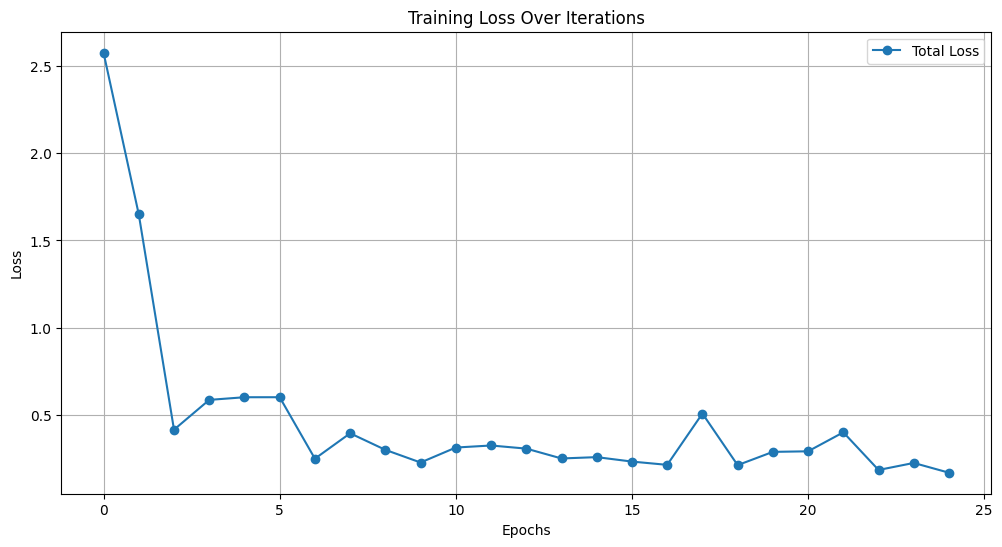

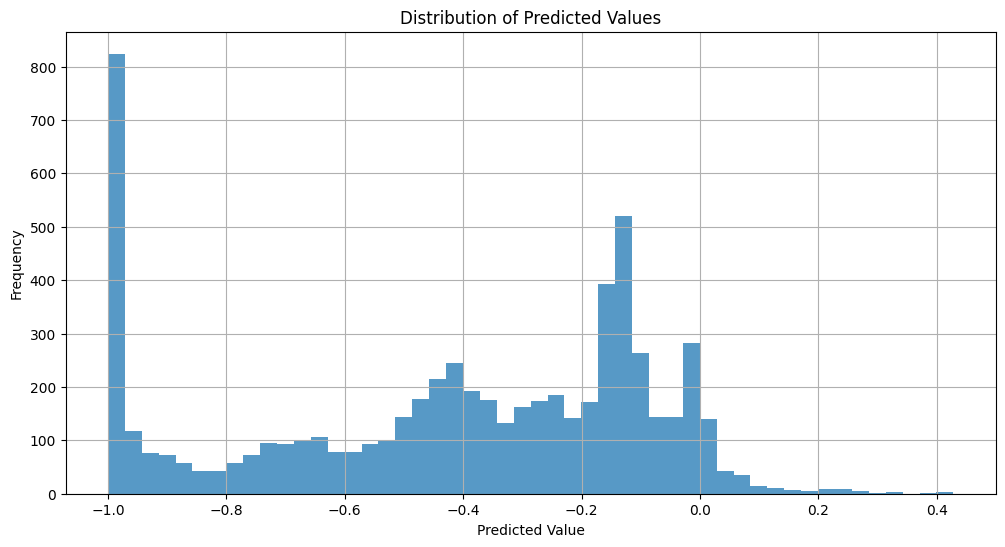

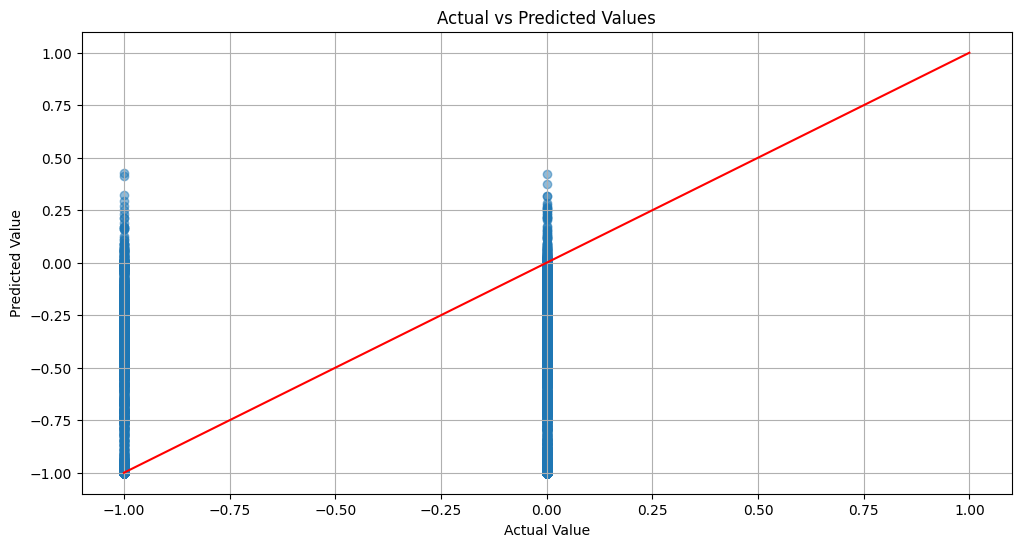

In [15]:
# 1. Plotting the real loss data
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Total Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# 2. Distribution of Predicted Values
plt.figure(figsize=(12, 6))
plt.hist(predicted_values, bins=50, alpha=0.75)
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.plot([-1, 1], [-1, 1], 'r')  # red line for ideal prediction
plt.grid(True)
plt.show()

These visualizations are instrumental in the iterative process of model development and tuning. By analyzing the plots, developers can make informed decisions about when to stop training (e.g., early stopping when the loss no longer decreases) or when to adjust hyperparameters for better performance.

---

### Model Saving Process

Saving the trained model is a critical step in the machine learning workflow. It allows for the preservation of the model's state at a particular point in time, enabling future predictions without the need to retrain.

**Saving the Dual-Head Neural Network Model**:
- **Purpose**: To store the trained neural network weights and biases so that the model can be reloaded and used for evaluation or further training at a later time.
- **Process**:
  - The `state_dict` of the model, which contains all the learnable parameters (weights and biases), is saved to a file.
  - The chosen file format `.pth` is a common PyTorch file extension for saving model checkpoints.
- **Code Explanation**:
  - `model_path`: A string that specifies the file path and name where the model's `state_dict` will be saved.
  - `torch.save()`: A PyTorch function that saves the `state_dict` to the specified path.
- **Output**: A confirmation message indicating the successful saving of the model and its file location.

**Usage**:
- After training, the model is saved to the specified path.
- The saved model can be easily shared or deployed in different environments.
- To use the saved model, one would reload the `state_dict` into a model with the same architecture using `torch.load()` and `model.load_state_dict()`.

**Benefits**:
- **Efficiency**: There is no need to retrain the model to make predictions on new data.
- **Reproducibility**: The exact state of the model is preserved, ensuring consistent predictions.
- **Transfer Learning**: The saved model can be used as a starting point for training on new tasks with similar data.

This step ensures that the computational investment in training the model is not lost, and the model's learned knowledge is retained for future use.

In [18]:
model_path = ".\Models\dual_nn_model_saved.pth"
# torch.save(dual_nn_model.state_dict(), model_path)

# print(f"Model saved to {model_path}")

Certainly, here's how you can incorporate the information about the experimental models into the explanation for the code that loads the model:

---

## Model Loading with an Experimental Twist:

As we approach the stage where we load our AI model from disk, it's worth noting that our repository contains more than just a single, definitive model. Within the `Models` folder lies an assortment of experimental models, each representing a different training regimen that our AI has undergone.

### Extended Explanation:

- **Model Repository**: The `Models` folder serves as a repository that contains various iterations of our neural network. Each model encapsulates a unique learning experience, having been trained under different conditions and parameters.

- **Loading Mechanism**: The loading code is designed to be flexible, allowing us to resurrect any of these models from their saved state. By doing so, we can directly compare the performance of different training strategies or continue to refine them further.

In [19]:
loaded_model = ImprovedDualHeadNeuralNetwork()
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

print("Model loaded from disk.")

Model loaded from disk.


- **Experimental Insights**: With these models at our disposal, we can conduct a series of experiments to observe various learning behaviors. For instance, one model might reveal how the AI performs after a basic level of training, while another might showcase advanced strategic depth achieved through extended self-play.

- **Diversity in Learning**: This collection of models is crucial for understanding the spectrum of learning that our AI is capable of. Each model is a snapshot in the timeline of the AI's development, providing insights into how different tweaks in the learning process affect its gameplay.

By maintaining this diversity of models, we not only have a way to benchmark the progress of our AI but also the ability to demonstrate the impact of different learning algorithms and parameters. It's a practical way to visualize the growth of AI capabilities and to select the most effective training approach for future enhancements.

---

### Game-Playing Function Description

The `play_games` function is designed to pit two models against each other in a series of games to evaluate their performance. This function is useful for comparing the relative strengths of two models in a controlled, competitive environment.

**Function Overview**:
- **Purpose**: To simulate a series of games between two different models and record their performance in terms of wins and draws.
- **Process**:
  - Runs a loop for the specified number of games.
  - Alternates which model starts first in each game to ensure fairness.
  - Models take turns to play moves until the game is won or drawn.
  - Keeps track of the outcomes to calculate the winning percentages.

**Code Explanation**:
- `model1_wins`, `model2_wins`, `draws`: Counters for each possible outcome.
- `for game_num in range(num_games)`: Iterates through the number of games to be played.
- `root_node`: Initializes the state of the game board for the MCTS algorithm.
- `MCTSWithNN(model)`: Creates a new MCTS instance with the given model to determine the best move.
- `search(root_node)`: Performs the MCTS search to find the best move from the current board state.
- `make_move(best_move)`: Executes the best move on the game board.
- `if game.check_win()`: Checks if the current state is a winning state.
- `else`: If the game is not won, it could be a draw.

**Usage**:
- To evaluate how well a model plays the game of Tic-Tac-Toe.
- To determine if a newly trained model has improved over a previous version.
- For benchmarking before deploying the model in a real-world application.

**Benefits**:
- **Fair Assessment**: By alternating starting players and using a large number of games, the function ensures a fair comparison between models.
- **Automated Evaluation**: Automates the process of playing multiple games, saving time and effort.
- **Performance Metrics**: Provides clear, quantitative measures of model performance.

The `play_games` function is a valuable tool for iterative model development, allowing developers to quantitatively assess improvements in AI models over time.

In [20]:
def play_games(model1, model2, num_games=30):
    model1_wins = 0
    model2_wins = 0
    draws = 0

    for game_num in range(num_games):
        game = TicTacToe()
        while not (game.check_win() or game.check_draw()):
            root_node = MCTSNode(game.board)
            if game_num % 2 == 0:  # Model1 starts as 'X' and Model2 as 'O'
                if game.current_player == 1:
                    best_move = MCTSWithNN(model1).search(root_node)
                else:
                    best_move = MCTSWithNN(model2).search(root_node)
            else:  # Model2 starts as 'X' and Model1 as 'O'
                if game.current_player == 1:
                    best_move = MCTSWithNN(model2).search(root_node)
                else:
                    best_move = MCTSWithNN(model1).search(root_node)
            game.make_move(best_move)

        if game.check_win():
            if game_num % 2 == 0:
                if game.current_player == -1:
                    model1_wins += 1
                else:
                    model2_wins += 1
            else:
                if game.current_player == -1:
                    model2_wins += 1
                else:
                    model1_wins += 1
        else:
            draws += 1

    return model1_wins/num_games, model2_wins/num_games, draws/num_games

### Visualization of Model Performance

The provided code snippet demonstrates how to use the `play_games` function to obtain the win rates of two models in a series of games, and then visualize the results using Matplotlib.

**Function Overview**:
- **Purpose**: To visualize the comparative performance of two models based on the outcomes of simulated games.
- **Process**:
  - Calls `play_games` function with two models as arguments.
  - Records the win rates and draw rate.
  - Presents the results in both a pie chart and a bar chart.

**Code Explanation**:
- `enhanced_model1 = EnhancedNeuralNetwork()`: Instantiates a new neural network model.
- `play_games(enhanced_model1, dual_nn_model_old)`: Simulates games between the newly instantiated model and an older version.
- `labels`, `sizes`, `colors`: Defines labels, size proportions, and colors for the pie chart.
- `fig1, ax1 = plt.subplots()`: Prepares a subplot for drawing.
- `ax1.pie(...)`: Creates a pie chart with the given sizes and colors.
- `ax1.axis('equal')`: Ensures the pie chart is circular.
- `plt.show()`: Displays the pie chart.

**Usage**:
- To compare the effectiveness of two different AI models in playing Tic-Tac-Toe.
- To visualize the win/loss/draw distribution in an easy-to-understand format.
- To report the performance of AI models in research or to stakeholders.

**Benefits**:
- **Intuitive Visualization**: Pie and bar charts provide a clear, visual representation of performance that is easy to interpret.
- **Immediate Insights**: Stakeholders can quickly grasp the performance differences between two models.
- **Customizable**: The visualization can be easily adjusted for different datasets or preferences.

The use of both pie and bar charts allows for a comprehensive visualization of the models' performance, catering to different preferences for data presentation. This approach is particularly useful for presentations or reports where visual aids can enhance the communication of the models' capabilities.

Model1's win rate: 43.33%
Model2's win rate: 43.33%
Draw rate: 13.33%


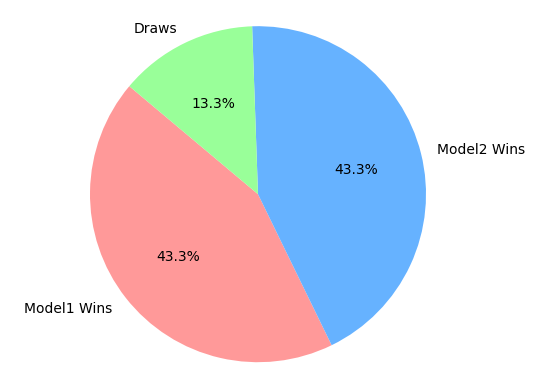

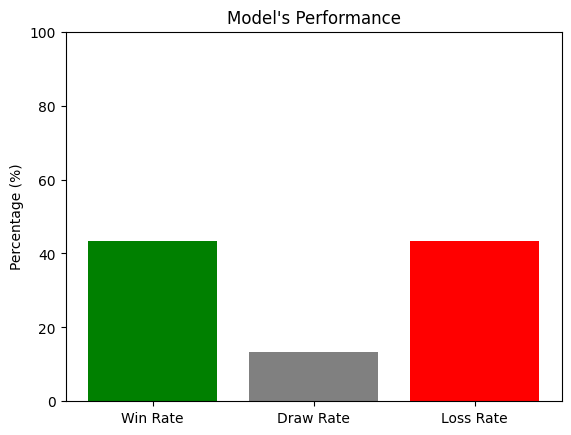

In [21]:
enhanced_model1 = EnhancedNeuralNetwork()

# Example usage:
model1_win_rate, model2_win_rate, draw_rate = play_games(enhanced_model1, dual_nn_model_old)

# Print results
print(f"Model1's win rate: {model1_win_rate*100:.2f}%")
print(f"Model2's win rate: {model2_win_rate*100:.2f}%")
print(f"Draw rate: {draw_rate*100:.2f}%")

# Plot results
labels = ['Model1 Wins', 'Model2 Wins', 'Draws']
sizes = [model1_win_rate, model2_win_rate, draw_rate]
colors = ['#ff9999','#66b2ff','#99ff99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')  
plt.show()

# Values to plot
values = [model1_win_rate*100, draw_rate*100, model2_win_rate*100]
labels = ["Win Rate", "Draw Rate", "Loss Rate"]

# Create bar plot
plt.bar(labels, values, color=['green', 'gray', 'red'])

# Add title and labels
plt.title("Model's Performance")
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Set y-axis limits

# Display the plot
plt.show()

### Game Recording Function for Model Analysis

The provided code snippet outlines a function designed to record the sequences of moves and board states during simulated games played by a model. This can be instrumental for analyzing the decision-making process of the model.

**Function Overview**:
- **Purpose**: To log the progression of game states and corresponding moves made by an AI model during multiple games.
- **Output**: A list of games, each being a sequence of tuples containing the board state before a move and the move itself, along with the game result.

**Code Explanation**:
- `record_games(model, num_games=10)`: Defines a function to record the specified number of games played by the provided model.
- `recorded_games = []`: Initializes a list to store the game records.
- Inside the loop, for each game:
  - `game = TicTacToe()`: A new game instance is created.
  - `game_record = []`: A list to store the sequence of moves and board states for the current game.
  - Within the inner loop:
    - `root_node = MCTSNode(game.board)`: A new tree node is created for the current board state.
    - `best_move = MCTS(model).search(root_node)`: The Monte Carlo Tree Search (MCTS) algorithm determines the best move.
    - `game_record.append((game.board.copy(), best_move))`: The current board state and the chosen move are appended as a tuple to the game record.
    - `game.make_move(best_move)`: The move is played on the board.
  - After the game ends, the result is determined and stored with the record of the game.
- `return recorded_games`: Returns the list of all recorded games and their outcomes.

**Usage**:
- To debug and improve the model by analyzing the decisions made at each step.
- To create a dataset of games for training or testing other models.
- To visualize the decision-making process for educational or reporting purposes.

**Benefits**:
- **In-Depth Analysis**: Allows for a thorough examination of the model's gameplay strategies.
- **Strategic Improvement**: Identifying patterns in the model's play can inform further training and refinement.
- **Data Collection**: Provides a structured dataset of played games for various applications.

By examining the sequence of moves and the evolution of the board state for each game, researchers and developers can gain insights into the model's strengths and weaknesses. This can also facilitate a better understanding of the model's learning and adaptation over time, leading to more focused improvements in its architecture or training regimen.

In [22]:
def record_games(model, num_games=10):
    recorded_games = []
    for _ in range(num_games):
        game = TicTacToe()
        game_record = []
        while not (game.check_win() or game.check_draw()):
            root_node = MCTSNode(game.board)
            best_move = MCTS(model).search(root_node)
            game_record.append((game.board.copy(), best_move))
            game.make_move(best_move)
        result = 0
        if game.check_win():
            result = game.current_player * -1
        recorded_games.append((game_record, result))
    return recorded_games

# Example usage:
games = record_games(enhanced_model1)
# This will give a list of games, where each game is a list of (board, move) tuples.


### Game Visualization Function for TicTacToe

The `visualize_game_horizontal` function serves as a dynamic visualizer for representing the progress of a TicTacToe game. This visualization tracks the sequence of moves and presents the evolving game state in a format that's intuitive and insightful for analysis.

- **Dynamic Subplot Generation**: A series of subplots is generated, with one subplot corresponding to each move in the game, providing a snapshot of the board at that stage.
- **Visualization Mechanics**: Within each subplot:
  - The board's state is depicted, marking 'X' and 'O' in distinct colors (red for 'X', blue for 'O'), providing immediate visual feedback on player actions.
  - The latest move is accentuated with a green square, drawing attention to the most recent decision in the gameplay.
  - The TicTacToe grid is emulated with appropriate axis ticks and grid lines, ensuring a familiar representation of the play area.
  - An inverted y-axis reflects the traditional board layout, enhancing the natural interpretation of the game state.

- **Outcome Annotation**: Upon the game's completion, a title is designated to reflect the outcome—victory for 'X' or 'O', or a declaration of a draw. This acts as a quick summary of the game's result.
- **Sequential Display**: The game record is processed in sequence, unfolding the game's narrative from start to finish, allowing viewers to trace the strategic developments throughout the match.
- **Batch Visualization**: By iterating through a collection of game records, the function facilitates the batch visualization of multiple games, offering a broader view of the model's gameplay patterns and tendencies.

This visualization approach not only serves as a tool for human observers to understand the model's strategic choices but also acts as a debugging aid, enabling the identification of patterns or anomalies in the AI's playing style. By capturing the essence of each move and its impact on the game, it provides a comprehensive look at the AI's decision-making process in a visually accessible manner.

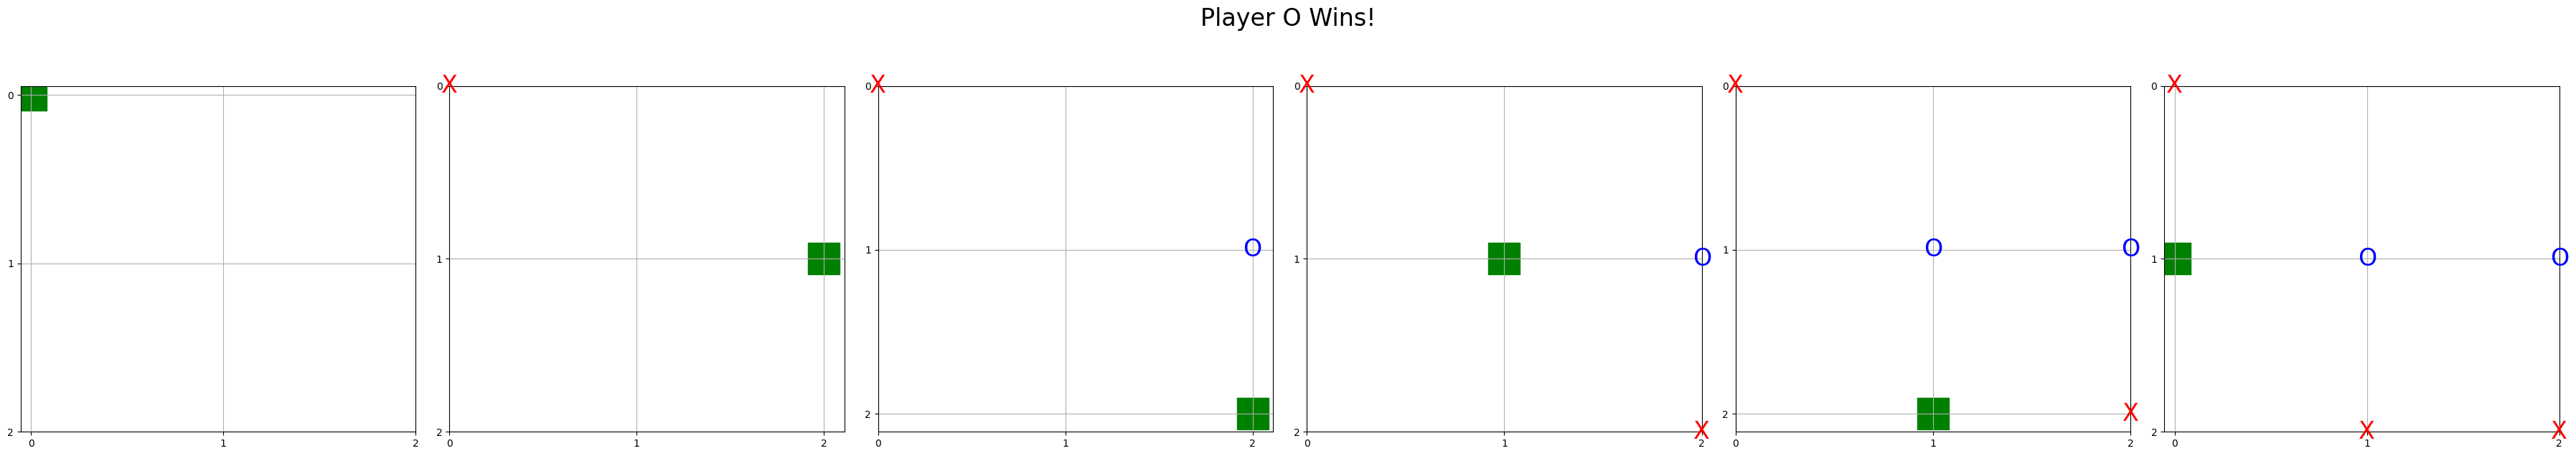

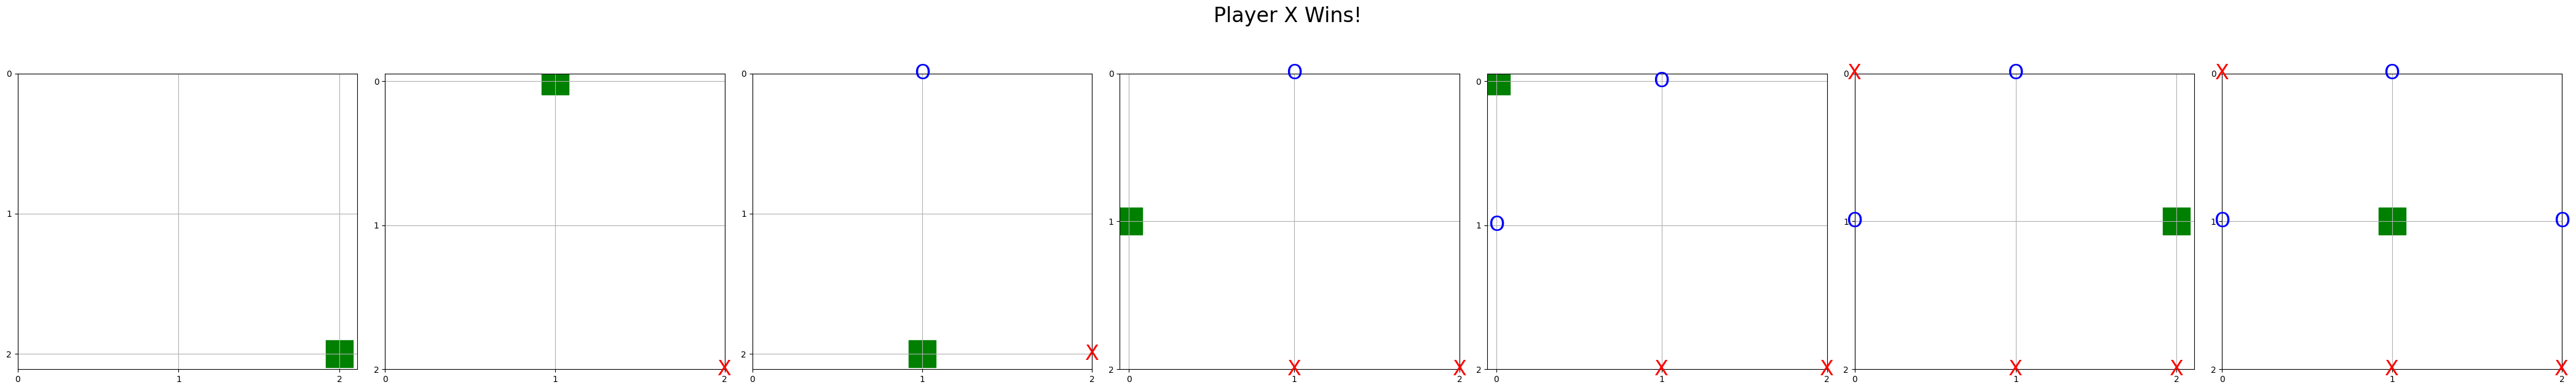

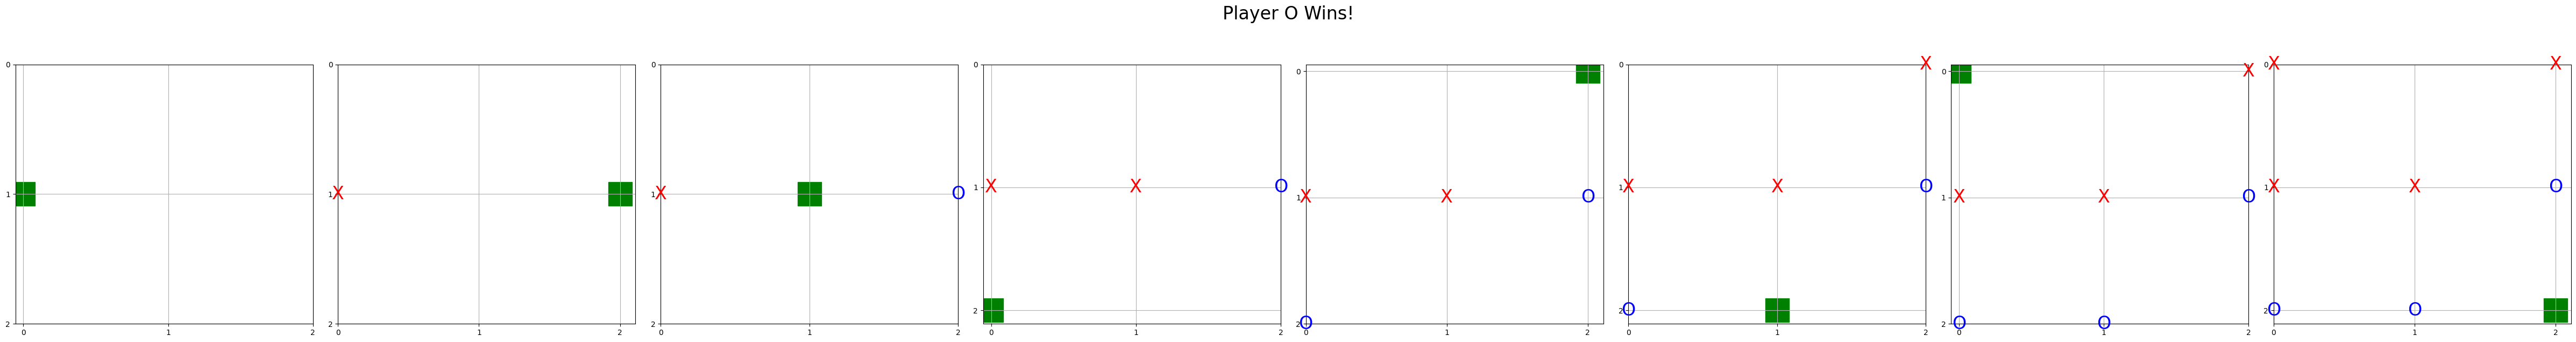

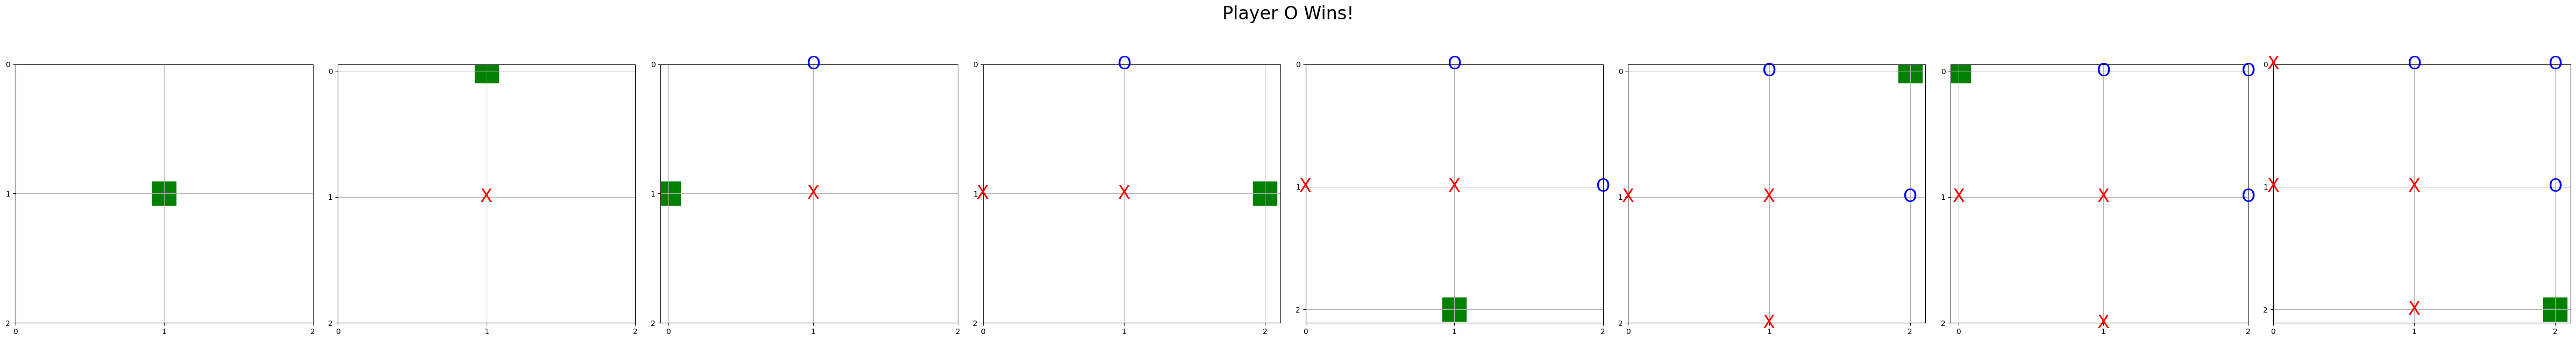

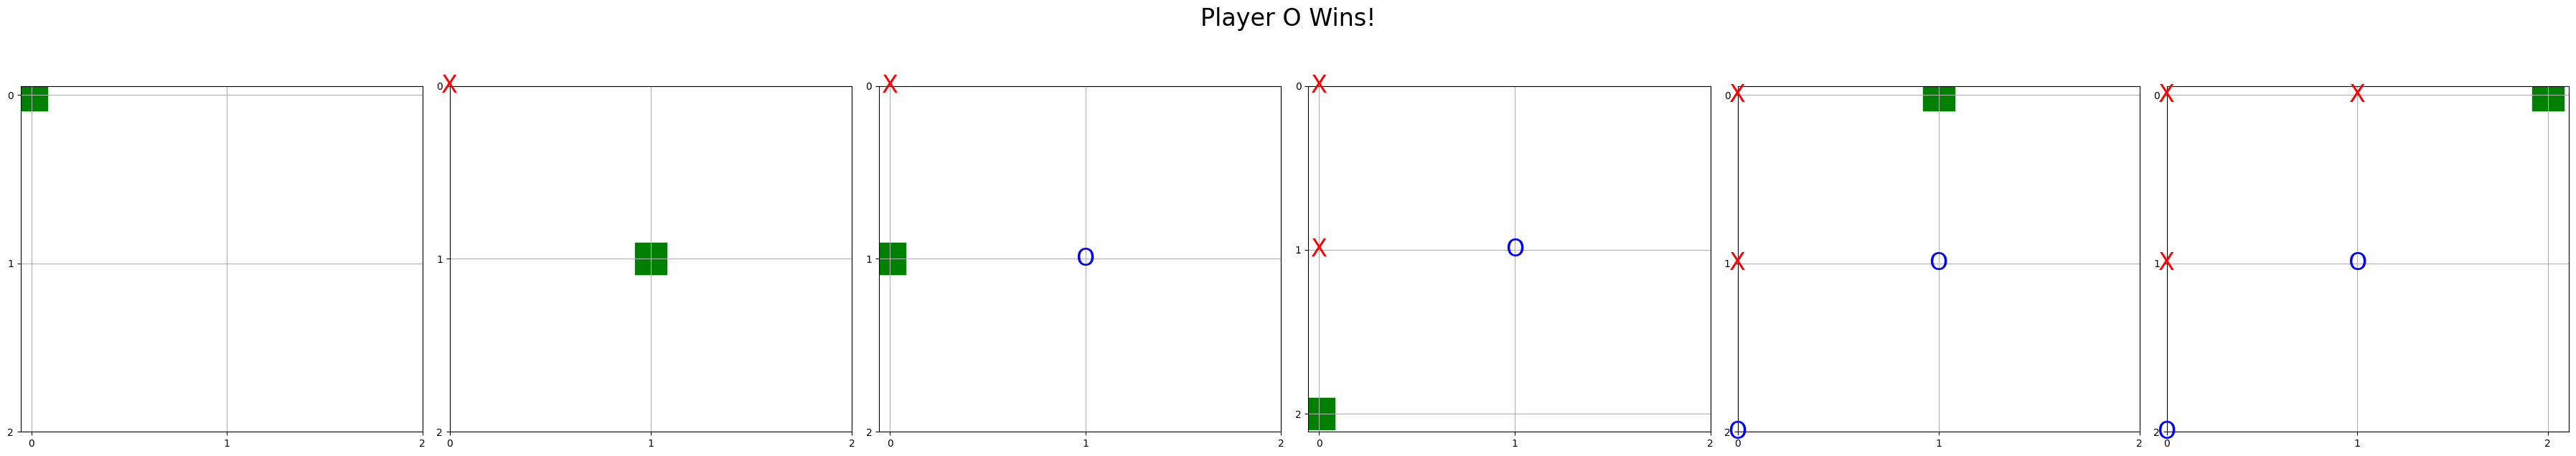

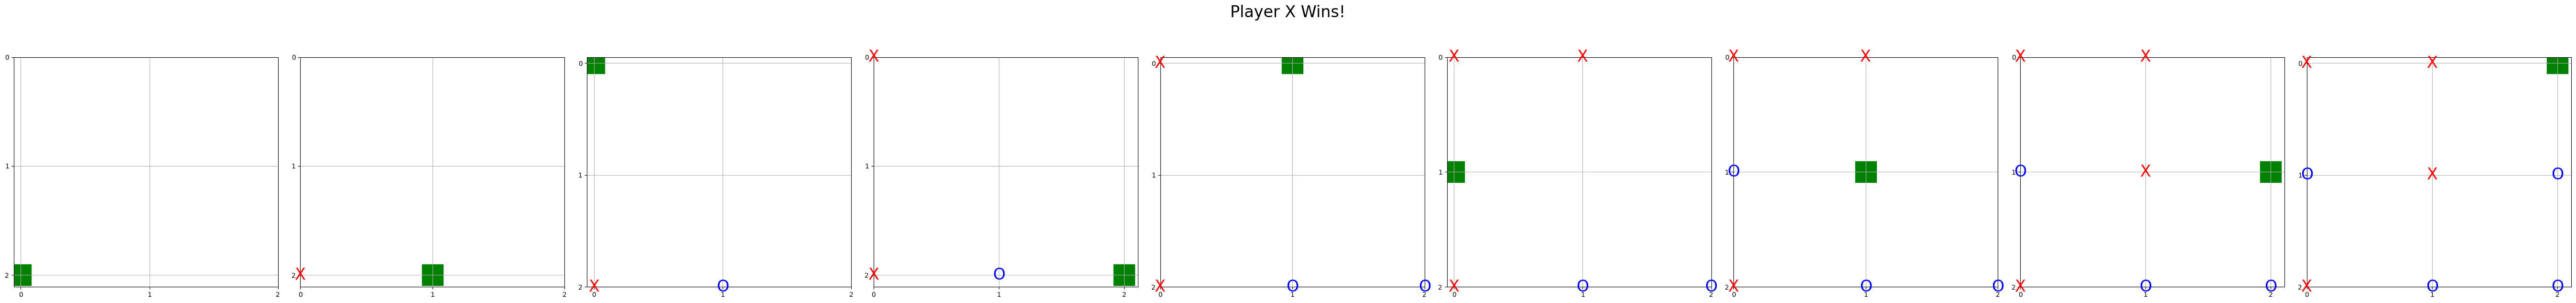

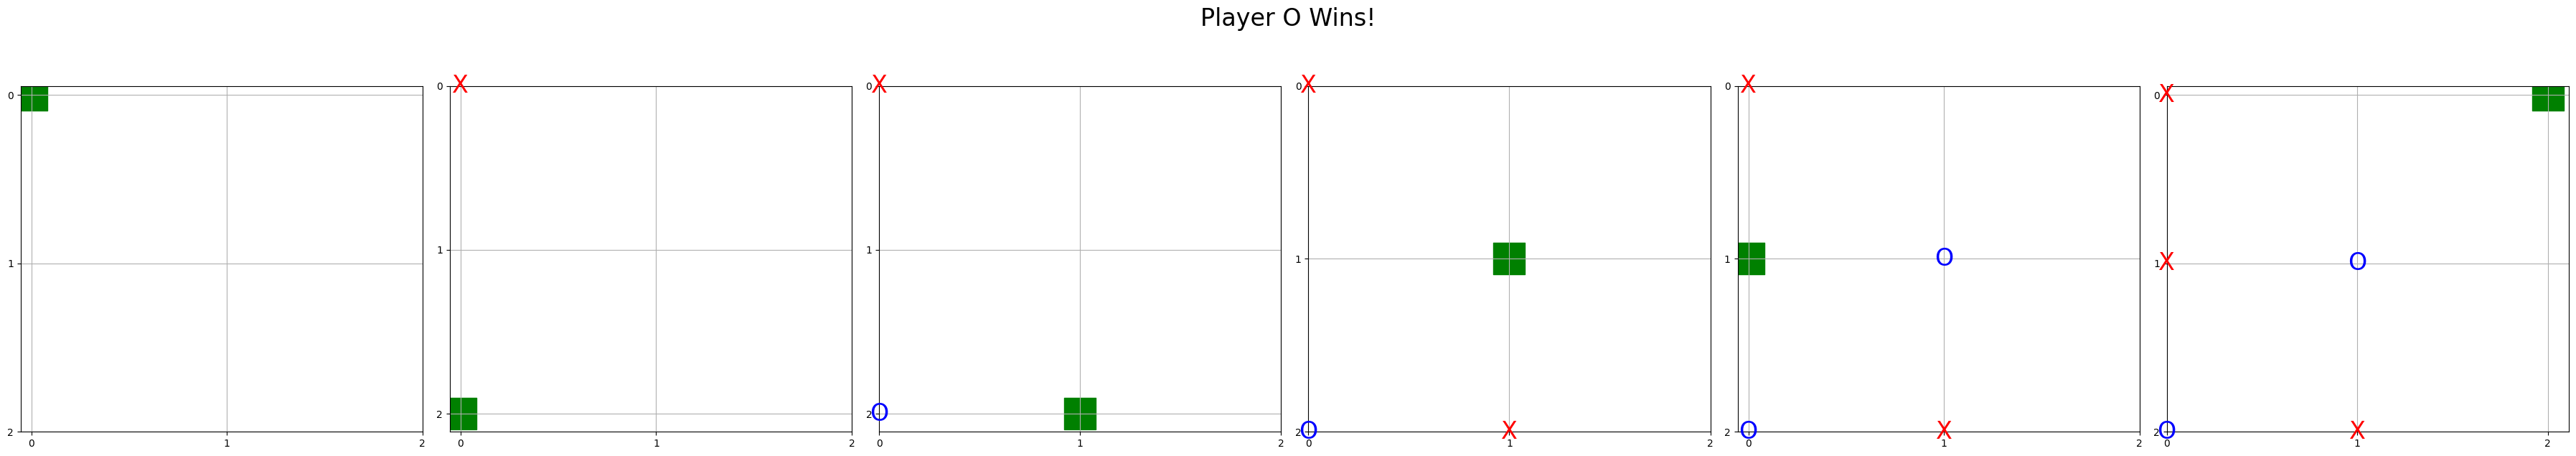

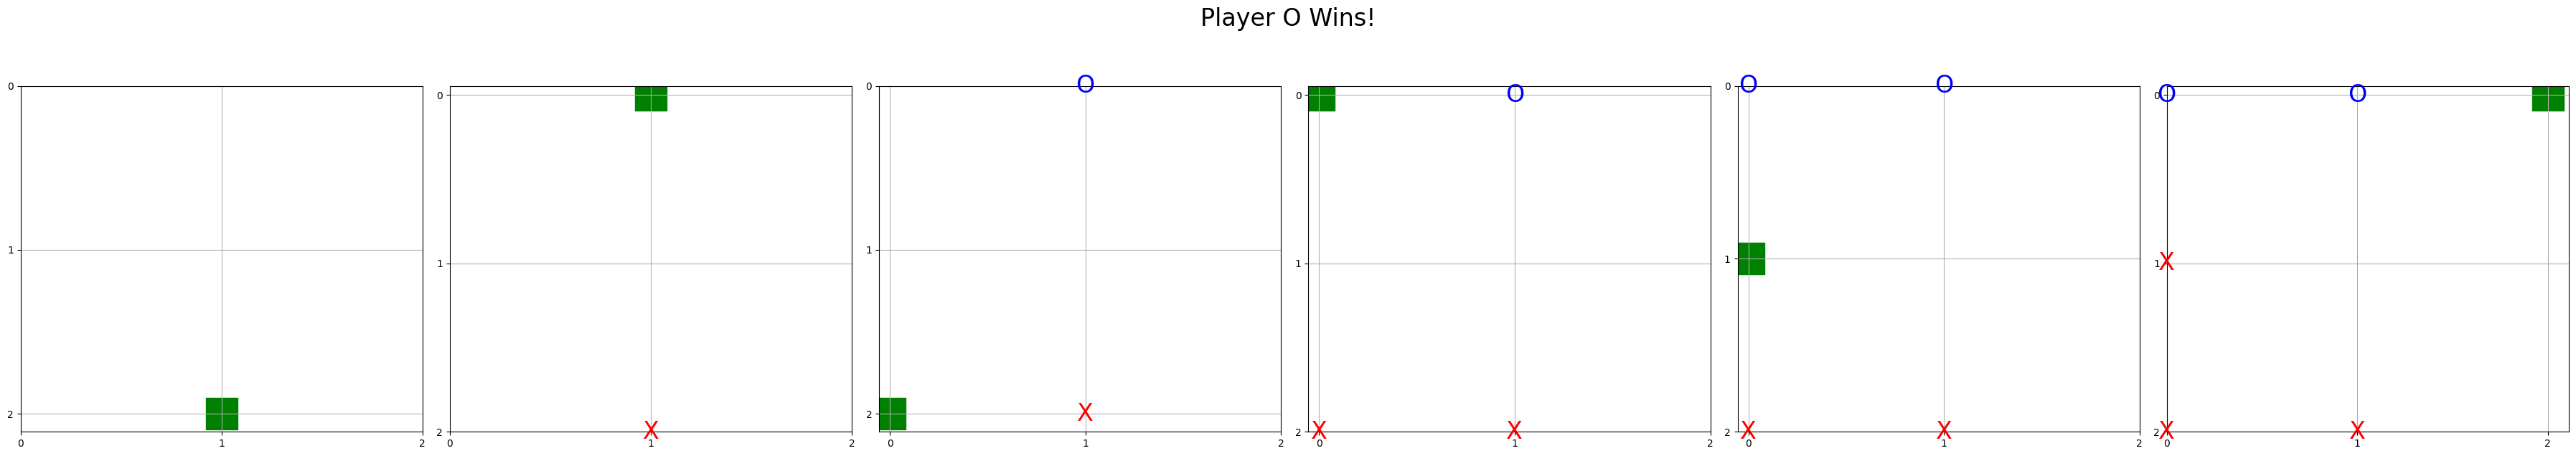

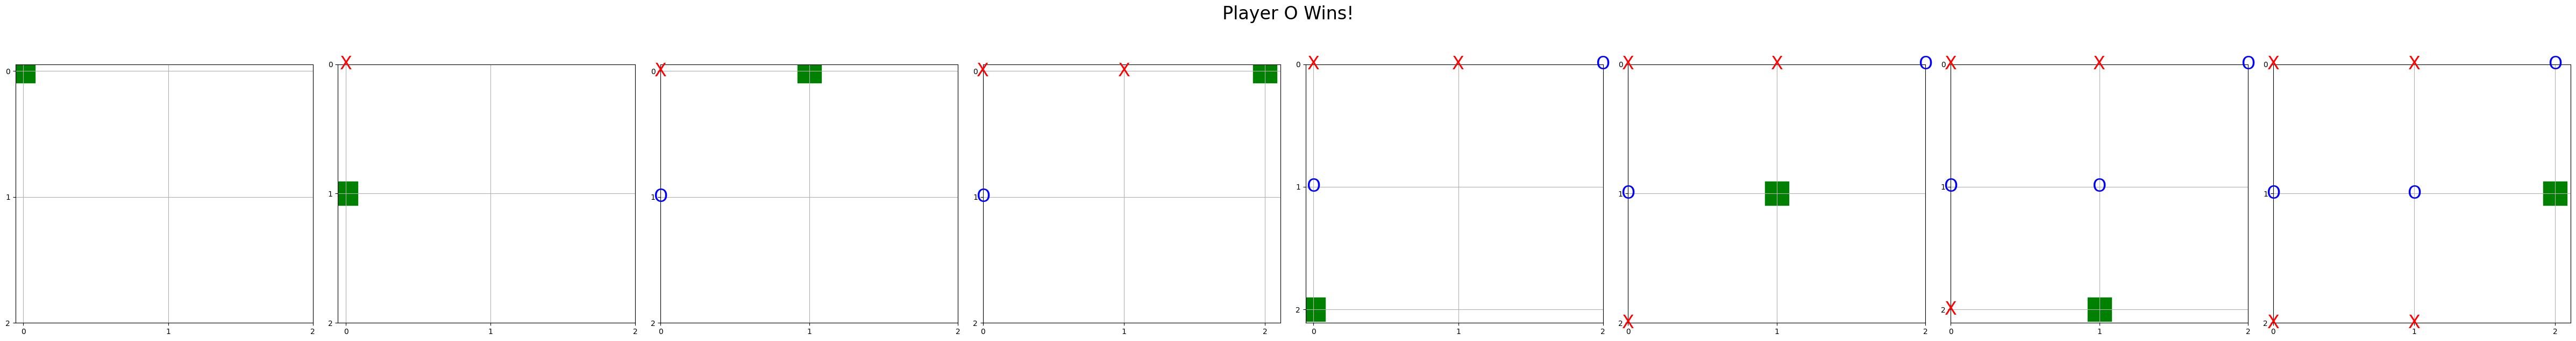

In [24]:
def visualize_game_horizontal(game_record, result):
    n = len(game_record)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    
    for idx, (board, move) in enumerate(game_record):
        ax = axes[idx]
        
        for i in range(3):
            for j in range(3):
                if board[i, j] == 1:
                    ax.text(i, j, 'X', color='red', fontsize=24, ha='center', va='center')
                elif board[i, j] == -1:
                    ax.text(i, j, 'O', color='blue', fontsize=24, ha='center', va='center')
        
        # Highlight the last move with a green square
        ax.scatter(move[0], move[1], color='green', s=1000, marker='s')
        
        ax.set_xticks([0, 1, 2])
        ax.set_yticks([0, 1, 2])
        ax.grid(True)
        ax.invert_yaxis()  # Invert y-axis for proper Tic Tac Toe board orientation

    if result != 0:
        title = "Player X Wins!" if result == 1 else "Player O Wins!"
    else:
        title = "It's a Draw!"
    
    fig.suptitle(title, fontsize=24, y=1.05)
    plt.tight_layout()
    plt.show()


for game_record, result in games[:9]:  # Visualize the first 10 games
    visualize_game_horizontal(game_record, result)



### Human vs. Model Gameplay Function for TicTacToe

To test our model in a real game, we can create an interactive environment where the model plays against a human. 

The `play_human_vs_model` function is designed to facilitate an interactive game of TicTacToe between a human player and an AI model. Here's a detailed explanation of how this function and its helper functions operate:

#### Display Board:

- `display_board(game)`: This function prints the TicTacToe board in a human-readable format. It labels rows and columns with indices and represents the marks ('X' and 'O') according to the current state of the game board.

#### Get Human Move:

- `get_human_move(game)`: It prompts the human player to enter a move in the format 'row col'. It validates the input to ensure the move is available (i.e., the chosen cell is empty) and handles any input errors gracefully by requesting the user to enter the move again.

#### Choose Difficulty:

- `choose_difficulty()`: This function asks the human player to set the difficulty level of the game. The level influences the number of simulations the MCTS will run, with 'easy' resulting in fewer simulations and 'hard' resulting in more, making the AI's move selection more challenging.

#### Get Best Move for Model:

- `get_best_move_for_model(board, model, simulations)`: Given the current state of the board and the difficulty level, this function determines the AI's best move using MCTS with the specified number of simulations. If the board is empty, a default first move is chosen for efficiency.

#### Choose Starting Player:

- `choose_starting_player()`: This function asks whether the human player wishes to start the game or not. It ensures that the input is either 'yes' or 'no' and sets the starting player accordingly.

#### Gameplay Loop:

- `play_human_vs_model(model)`: The main function orchestrates the game flow. It initializes the game, decides who starts based on the human player's preference, and sets the difficulty level. The game loop then alternates between the model's move and the human's move until the game ends. After each move, the board is displayed, and once the game concludes, it announces the winner or declares a draw.

In [ ]:
def display_board(game):
    board = game.board
    print("  0 1 2")
    print("  ------")
    for i in range(3):
        row_display = [str(i)]
        for j in range(3):
            if board[i, j] == 1:
                row_display.append("X")
            elif board[i, j] == -1:
                row_display.append("O")
            else:
                row_display.append(" ")
        print("|".join(row_display))
        if i != 2:
            print("  ------")



def get_human_move(game):
    available_moves = game.available_moves()
    while True:
        try:
            row, col = map(int, input("Enter your move as 'row col': ").split())
            if (row, col) in available_moves:
                return (row, col)
            else:
                print("Invalid move. Please try again.")
        except ValueError:
            print("Invalid input. Please enter your move as 'row col'.")

def choose_difficulty():
    while True:
        choice = input("Choose difficulty (easy/medium/hard): ").lower()
        if choice in ["easy", "medium", "hard"]:
            return choice
        else:
            print("Invalid choice. Please choose between 'easy', 'medium', or 'hard'.")

def get_best_move_for_model(board, model, simulations):
    if np.all(board == 0):  # check if the board is empty
        return (1, 1)
    
    root_node = MCTSNode(board)
    mcts = MCTSWithNN(model, num_simulations=simulations)  # Use the enhanced MCTS with specified simulations
    best_move = mcts.search(root_node)
    return best_move

def choose_starting_player():
    while True:
        choice = input("Do you want to start? (yes/no): ").lower()
        if choice in ["yes", "no"]:
            return choice == "yes"
        else:
            print("Invalid choice. Please enter 'yes' or 'no'.")
            
def play_human_vs_model(model):
    game = TicTacToe()
    
    human_starts = choose_starting_player()
    if human_starts:
        game.current_player = -1
    else:
        game.current_player = 1

    difficulty = choose_difficulty()
    mcts_simulations = {"easy": 100, "medium": 1000, "hard": 5000}

    while not (game.check_win() or game.check_draw()):
        if game.current_player == 1:  # Assuming the model plays as 'X'
            best_move = get_best_move_for_model(game.board, model, mcts_simulations[difficulty])
            game.make_move(best_move)
            print("Model's move:", best_move)
            display_board(game)
        else:
            human_move = get_human_move(game)
            game.make_move(human_move)
            display_board(game)

    if game.check_win():
        winner = -game.current_player
        if winner == -1:
            print("Congratulations! You win!")
        else:
            print("Model wins!")
    else:
        print("It's a draw!")

play_human_vs_model(loaded_model)

The function is designed to be user-friendly, providing clear instructions and feedback to the human player. It leverages the aforementioned helper functions to handle game logic, user input, and the AI's decision-making process, resulting in a seamless and engaging game experience. This will help you assess how well your model is trained.

---

## Conclusion and Core Objective:

In this project, we've embarked on a fascinating journey to engineer an AI that can play TicTacToe with remarkable proficiency, mirroring the groundbreaking techniques of the AlphaGo Zero algorithm. At the heart of this venture is the main idea: to craft a neural network, trained through the Monte Carlo Tree Search (MCTS) algorithm, that ascends to an advanced level of play in this classic game. The neural network's training utilizes MCTS to navigate the vast landscape of possible moves from any game state, favoring intelligent evaluation over random guesswork.

#### Central Thesis:

- **Integration of Neural Networks and MCTS**: By weaving together the predictive power of neural networks with the exploratory prowess of MCTS, we've endowed our AI with the capability to scrutinize and select moves as a seasoned player would, bypassing the need for traditional, exhaustive search techniques.

- **Neural Network with Dual Head**: The neural network brandishes a dual head — one for assessing board states (value) and the other for gauging the probabilities of potential moves (policy). This dualistic nature enables a comprehensive analysis of each game state, much like the approach taken by AlphaGo Zero.

#### Key Components Reiterated:

- **Self-Play for Autonomous Learning**: Our AI engages in self-play, where it acts as both competitor and collaborator, thereby generating a rich dataset from which to learn. Each game played is a step towards a more nuanced understanding of TicTacToe's intricate dynamics.

- **Strategic Evolution via Reinforcement Learning**: As the AI battles itself, it's not just learning to win; it's evolving a strategic consciousness, refining its gameplay through reinforcement learning principles. Each iteration is a stride towards a more refined algorithm that plays with foresight and adaptability.

- **Human Interaction for Practical Testing**: We've incorporated a mode that pits human intellect against AI intuition, offering multiple levels of difficulty. This interactive facet provides a tangible measure of the AI's capability and a playground for human players to experience the AI's strategic depth.

#### Reflections with the Core Objective in Mind:

This project is not just a technical showcase but also a conceptual paradigm of machine learning's transformative potential. We have demonstrated that with the right algorithmic interplay, even a game as straightforward as TicTacToe can be a canvas for AI to exhibit learning akin to human-like understanding.

By harmonizing the MCTS algorithm with a neural network, we've taken a leap beyond conventional programming methods, tackling the game's inherent complexity with an elegance that comes from a marriage of exploration and evaluation. Our AI's trajectory from a blank slate to a strategic virtuoso stands as a testament to the powerful combination of neural network evaluation and MCTS foresight — a synergy that is the cornerstone of our project's vision.